#### From Location to run ISOFIT to get turbidity and save that run 

In [1]:
# Import all packages 
import spectral.io.envi as envi
from spectral import *
import scipy as s
from scipy.linalg import norm
import scipy.optimize as opt
from scipy.stats import norm as nom
import pylab as plt
import h5py
#import figure_style
import numpy as np
from shapely import geometry 
import matplotlib.pyplot as plt
import sambuca_core as sbc
import h5py
import matplotlib.transforms as mtransforms

ModuleNotFoundError: No module named 'spectral'

Import all data 

In [54]:
#t225529
#glt29 = envi.open('../prm20140428/L1B/prm20140428t225529_rdn_v1c/prm20140428t225529_ort_glt.hdr') # original pixel > fixed pixel 
#ort29 = envi.open('../prm20140428/L1B/prm20140428t225529_rdn_v1c/prm20140428t225529_ort_igm.hdr') # actual georef
#rd29 =  envi.open('../prm20140428/L1B/prm20140428t225529_rdn_v1c/prm20140428t225529_rdn_v1c_img.hdr')

# t232525  ... DON'T WORRY ABOUT NOW
#glt25 = envi.open('../prm20140428/L1B/prm20140428t232525_rdn_v1c/prm20140428t232525_ort_glt.hdr') # original pixel > fixed pixel 
#ort25 = envi.open('../prm20140428/L1B/prm20140428t232525_rdn_v1c/prm20140428t232525_ort_igm.hdr') # actual georef
#rd25 =  envi.open('../prm20140428/L1B/prm20140428t232525_rdn_v1c/prm20140428t232525_rdn_v1c_img.hdr') #radiance 


glt950 = envi.open('../prm20140428/L1B/prm20140428t230950_rdn_v1c/prm20140428t230950_ort_glt.hdr') # original pixel > fixed pixel 
ort950 = envi.open('../prm20140428/L1B/prm20140428t230950_rdn_v1c/prm20140428t230950_ort_igm.hdr') # actual georef
rd950 =  envi.open('../prm20140428/L1B/prm20140428t230950_rdn_v1c/prm20140428t230950_rdn_clip.hdr') #radiance 
atrm950 = envi.open('../prm20140428/L2_ref_cedric/PRISM20140428t230950_corr_v4_ort.hdr')

# Atrem Turb and in situ turbidity 
atrem_turb = h5py.File('../prm20140428/HDF/Predicted_Turbidity_DOC_PRISM20140428t225529_corr_v4_ort.hdf','r') #HDF file 

insitu_turb = np.loadtxt('../insitu/FNU_utm.txt') 
wavelengths = np.loadtxt('../Wavelength/PRISM_micorns_wavelength.txt')

Inputs that user can change: 

In [55]:
# Inputs: flight line and location of turbidity 
ort = ort950
glt = glt950
rd = rd950
it = 2620 
atrm = atrm950

#Wavelengths and channels 
wave = wavelengths[3:-1,1]
fwhm = wavelengths[3:-1,2]

Find the in situ data that is within the flight line, and get the index 

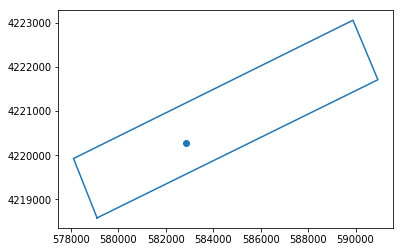

(1792, 295, 0)
3150
370
23.71835071


In [56]:
insitu_test = insitu_turb[it,:]
Ei = insitu_test[0]
Ni = insitu_test[1]
is_turb = insitu_test[4]

#Radiance Data Easting Northing / Flight line location from ORT 
def get_geo(ort_file):
    E = ort_file[:,:,0]
    N = ort_file[:,:,1]
    return E,N 

# Define the polygon of the flight line 
def flight_poly(E,N):
    tl = (E[0,0],N[0,0])
    tr = (E[-1,0],N[-1,0])
    bl = (E[0,-1],N[0,-1])
    br = (E[-1,-1],N[-1,-1])

    c = [tl,bl,br,tr]

    pol = geometry.Polygon(c)
    return pol 
   
# Run the two functions 
E,N = get_geo(ort) 
poly29 = flight_poly(E,N)

test = geometry.Point(Ei,Ni)

# Plot where the polygon is and where point is 
plt.plot(*poly29.exterior.xy)
plt.scatter(Ei,Ni)
plt.show()

sample = glt[:,:,0] # define the sample in GLT
lines = glt[:,:,1] # define the lines in GLT 


# If the point is within the polygon then find the pixel location the point is on, otherwise skip to the next pixel 
if test.within(poly29) == True: 
    norm_long = np.absolute(E - Ei)
    norm_lat = np.absolute(N-Ni)
    t = norm_long + norm_lat
    ind = np.unravel_index(np.argmin(t, axis=None), norm_long.shape)
    print(ind)
   
    k = np.where((sample == ind[1]) & (lines == ind[0])) #Where the index is in the GLT 
    
    if k[0].size == 0: 
        print('Point not in GLT')
    else: 
        line = int(k[0].reshape(1))
        print(line)
        row = int(k[1].reshape(1))
        print(row)
else: 
    print('Not within flightline')
print(is_turb)

Use the index to get the radiance from PRISM, to be run in ISOFIT, also now index for ATREM data 

3150 370


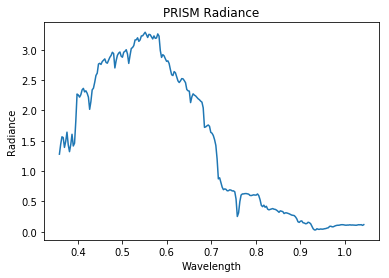

In [57]:
rd1 = rd[line,row,:]
bands = rd1.shape[2]
rd_iso_clip = rd1.reshape(bands)
data = np.array([wave,rd_iso_clip])
plt.plot(wave,rd_iso_clip)
plt.xlabel('Wavelength')
plt.ylabel('Radiance')
plt.title('PRISM Radiance')
#plt.plot(wave,reflectance[-1,:])
#plt.plot(wave,reflectance[-2,:])
np.savetxt('../isofit/examples/GrizzlyBay/remote/prm20140428t230950.txt',data.T)
print(line,row)

## NOW RUN ISOFIT

Use the output from ISOFIT and get turbidity

In [58]:
# Output from ISOFIT 
iso1 = np.loadtxt('../isofit/examples/GrizzlyBay/output/prm20140428t2309505_rfl.txt')
iso = iso1[:,1]
i_error = np.loadtxt('../isofit/examples/GrizzlyBay/output/prm20140428t230950_post.txt')

In [59]:
#errors = i_error
#errors = errors[0:25,:]

#errors = np.vstack((errors,i_error))
#np.savetxt('iso_error/iso_error_9.txt',errors.T)

#print(errors.shape)


In [983]:
# Save all of the reflectances:  
#reflectance = iso
#reflectance = reflectance[0:25,:]

#reflectance = np.vstack((reflectance,iso))
#np.savetxt('iso_reflectance/iso_reflectance_9.txt',reflectance.T)

#print(reflectance.shape)

Get the spectrum for the ATRM reflectance data 

In [60]:
# Atrm corrected reflectance 
atrm_ref = atrm[line, row, 4:246]
atrm = atrm_ref.reshape(bands)

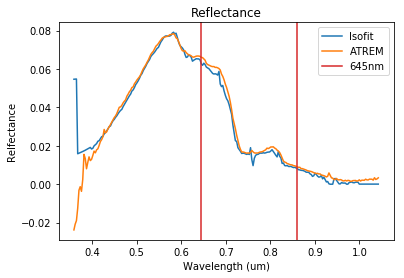

In [69]:
plt.plot(wave,iso)
plt.plot(wave,atrm)
#plt.plot(0.645,y)
plt.axvline(x=0.645,color = 'C3')
plt.axvline(x=0.860,color = 'C3')
plt.title('Reflectance')
plt.xlabel('Wavelength (um)')
plt.ylabel('Relfectance')
plt.legend(['Isofit','ATREM','645nm'])

Get turbidity from Dogloitti for both ISOFIT and ATREM 

In [986]:
# Wavelength at 645
aT_645 = 228.1
cT_645 = 0.1641
# Wavelength at 859
aT_860 = 2905.11
cT_860 = 0.2109 

# Get index of wavelength
wave_645 = np.abs(wave-.645)
ind = np.where(wave_645 == min(wave_645))[0]
# Get index of wavelength 
wave_860 = np.abs(wave-.860)
id860 = np.where(wave_860 == min(wave_860))[0]

iso_645 = iso[ind]
atrm_645 = atrm[ind]

iso_860 = iso[id860]
atrm_860 = atrm[id860]

sd_860 = i_error[id860]
sd_645 = i_error[ind]

def turb(A,c,p):
    T = (A*p)/(1-(p/c))
    return T

fnu_iso = turb(aT_860,cT_860,iso_860) 
fnu_atrm = turb(aT_860,cT_860,atrm_860)
fnu_iso645 = turb(aT_645,cT_645,iso_645)
fnu_atm645 = turb(aT_645,cT_645,atrm_645)

#print('Refl atrm at 860',atrm_860)
print('Turbidity at 860',fnu_iso[0],fnu_atrm[0])
print('Turbidity at 645',fnu_iso645[0],fnu_atm645[0])
print('Turbidity in situ:', is_turb)

t_fnu = (it, line, row, Ei, Ni, is_turb, fnu_iso[0], fnu_atrm[0], fnu_iso645[0], fnu_atm645[0], iso_860[0], 
         atrm_860[0], iso_645[0],atrm_645[0],sd_860[0],sd_645[0])

#t_header = ['index' 0, 'line'1, 'sample'2, 'E' 3,'N' 4,'T iso_860' 5,
#            'T atrm 860'6,'iso_645' 7, 'atrm_645' 8, 'iso refl_860' 9,'atrm_860' 10, 
#            'iso_645'11,'atrm_645'12,std 860 13, sd 645 14]
print(t_fnu)

Turbidity at 860 23.292120068689215 30.634209
Turbidity at 645 22.81735364759887 25.803362
Turbidity in situ: 27.65505706
(2600, 3152, 368, 582845.5067, 4220269.13, 27.65505706, 23.292120068689215, 30.634209, 22.81735364759887, 25.803362, 0.007724, 0.0100428015, 0.062148, 0.06696229, 0.002007, 0.001307)


Save the Results 

In [5]:
# For the first run: 
#t_f = np.array(t_fnu)
t_f = np.loadtxt('turb_outputs/turbidity_output_860_9.txt')
# All other runs: 
#t_f = np.vstack((t_f,t_fnu))
#np.savetxt('turb_outputs/turbidity_output_860_9.txt',t_f)

In [14]:
print(t_f[:,0])
print(t_f.shape)

t_f1 = t_f[t_f[:,0].argsort()] 
print(t_f1[:,0])

[2000. 2007. 2015. 2025. 2040. 2055. 2065. 2075. 2090. 3000. 3020. 3040.
 3050. 3060. 3070. 3080. 3100. 3110. 2100. 2110. 2120. 2130. 2140. 2150.
 2160. 2170. 2180. 2190. 2200. 2210. 2220. 2221. 2230. 2240. 2250. 2260.
 2270. 2370. 2480. 2580. 2680. 2280. 2300. 2320. 2340. 2360. 2380. 2400.
 2420. 2440. 2460. 2480. 2500. 2520. 2540. 2560. 2600.]
(57, 16)
[2000. 2007. 2015. 2025. 2040. 2055. 2065. 2075. 2090. 2100. 2110. 2120.
 2130. 2140. 2150. 2160. 2170. 2180. 2190. 2200. 2210. 2220. 2221. 2230.
 2240. 2250. 2260. 2270. 2280. 2300. 2320. 2340. 2360. 2370. 2380. 2400.
 2420. 2440. 2460. 2480. 2480. 2500. 2520. 2540. 2560. 2580. 2600. 2680.
 3000. 3020. 3040. 3050. 3060. 3070. 3080. 3100. 3110.]


## FIGURES 

(57,)


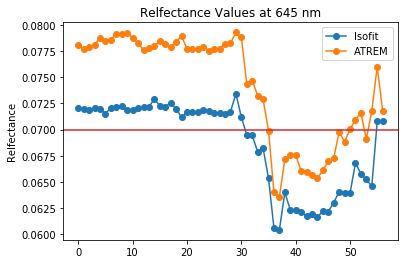

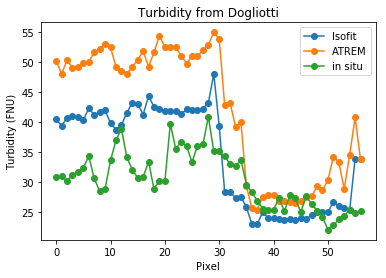

In [70]:
x = t_f1[:,8]
x1 = t_f1[:,9]
x2 = t_f1[:,5]
x3 = t_f1[:,6]
x4 = t_f1[:,7]

# Caluclate the real turbidity for ISOFIT: 
iref_645 = t_f1[:,12]
aref_645 = t_f1[:,13]

print(iref_645.shape)

def real_turb(ref_645,t_645,t_860):
    t_dog = []
    for v,i in enumerate(ref_645):
        if i < 0.05:
            t = t_645[v]
        if i > 0.07:
            t = t_860[v]
        else: 
            t = (1-i)*t_645[v] +i*t_860[0]
        t_dog.append(t)
    return t_dog

    
isoT = real_turb(iref_645,x,x3)
atrmT = real_turb(aref_645,x1,x4)
#print(isoT)


plt.plot(iref_645,'o-')
plt.plot(aref_645,'o-')

plt.axhline(y=0.07,color = 'C3')
plt.title('Relfectance Values at 645 nm')
plt.ylabel('Relfectance')
plt.legend(['Isofit','ATREM'])
plt.show()

plt.plot(isoT,'o-')
plt.plot(atrmT,'o-')
plt.plot(x2,'o-')
plt.title('Turbidity from Dogliotti')
plt.xlabel('Pixel')
plt.ylabel('Turbidity (FNU)')
plt.legend(['Isofit','ATREM','in situ'])
plt.show()



np.savetxt('turb_outputs/turbidity_output_dogliotti_1.txt',(isoT,atrmT))

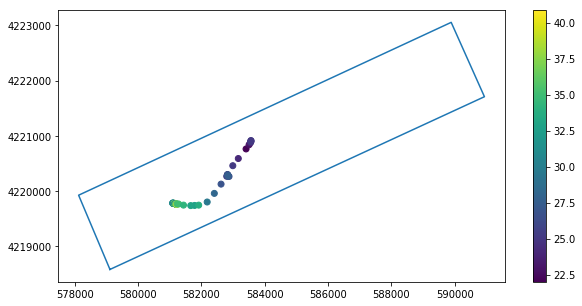

In [990]:
Ex = t_f[:,3]
Nx = t_f[:,4]

plt.plot(*poly29.exterior.xy)
plt.scatter(Ex,Nx,c=x2)
plt.colorbar()  
plt.show()

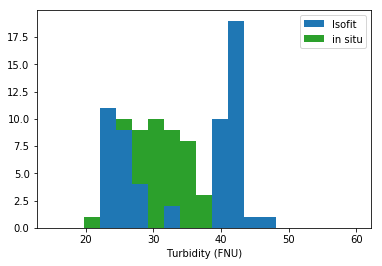

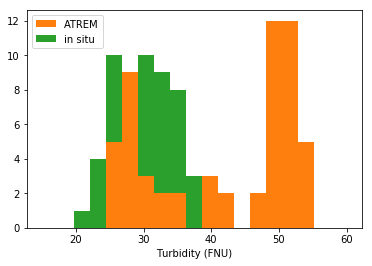

In [45]:
#plt.title('Turbidity ISOFIT at 645 um')
#plt.xlabel('Measured Turbidity (FNU)')
#plt.ylabel('Derived Turbidity ISOFIT (FNU)'
#plt.title('Turbidity ATRM at 645 um')
#plt.xlabel('Measured Turbidity (FNU)')
#plt.ylabel('Derived Turbidity ATRM (FNU)')

bins = np.linspace(15,60,20)
plt.hist(isoT,bins,alpha = 1,zorder = 2)

#plt.hist(atrmT,bins,alpha = 1, zorder = 3)
plt.hist(x2,bins, zorder = 1, color = 'C2')
plt.legend(['Isofit','in situ'])
plt.xlabel('Turbidity (FNU)')
plt.show()

plt.hist(atrmT,bins,alpha = 1, zorder = 3,color = 'C1')
plt.hist(x2,bins, zorder = 1, color = 'C2')
plt.legend(['ATREM','in situ'])
plt.xlabel('Turbidity (FNU)')
plt.show()

In [47]:
#RMSE: 

iso_rmse = np.sqrt(np.mean((isoT-x2)**2))
atrm_rmse = np.sqrt(np.mean((atrmT-x2)**2))
print(iso_rmse,atrm_rmse)

7.245688513029094 14.035454295253398


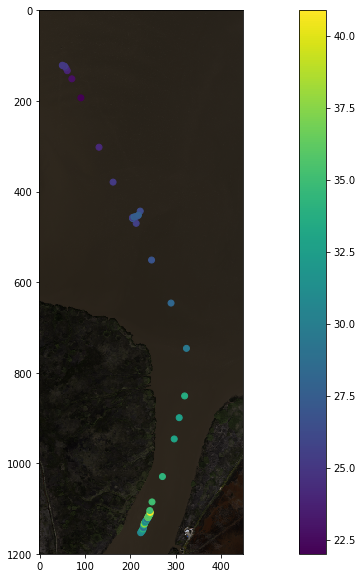

In [996]:
plt.rcParams['figure.figsize'] = [20, 10]
lines = t_f[:,1]-2700
rows = t_f[:,2]-150
v = imshow(rd[2700:3900, 150:600],(80,60, 40)) #3870
plt.scatter(rows,lines,c=x2)
plt.colorbar()  
plt.show()

#mtransforms.Affine2D().rotate_deg(70)

#plt.savefig('overlay_test.png', dpi = (1200*500)) 
#print(lines,rows)